In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import v2

In [2]:
class FLYDataset(Dataset):
    def __init__(self, path_to_data, mode="training", cam=0):

        # save selected camera and init lists
        self.cam = cam
        self.img_paths = []
        self.annotations = []
        self.H = 480
        self.W = 980

        # e.g path to the data, different classes, number of images per class, or image IDs per class
        if(mode != "test" and mode != "training"):
            raise ValueError("No such kind of data available")

        #Create path from path and parameter training/test
        full_path = os.path.join(path_to_data, mode, f"cam{cam}")
        # check if path exists. Path to data and kind are user inputs.
        if not os.path.isdir(full_path):
            raise FileExistsError(f"Wrong path {full_path}")

        # get the path to the annotation file and the path to the images
        annotation_file_path = os.path.join(full_path, "annotations", "annotations.npz")
        image_path = os.path.join(full_path, "images")
        # check if path exists. 
        if not os.path.isfile(annotation_file_path):
            raise FileExistsError(f"Wrong path to annotation file {annotation_file_path}")
        if not os.path.isdir(image_path):
            raise FileExistsError(f"Wrong path {image_path}")
        
        # load annotations
        annotations = np.load(annotation_file_path)
        self.annotations = annotations['points2d']

        for image_name in sorted(os.listdir(image_path)):
                # get the label as an int and the path of the image
                if(image_name.endswith(".jpg")):
                    self.img_paths.append(os.path.join(image_path, image_name))

        if len(self.img_paths) != len(self.annotations):
            raise IndexError("Number of images and annotations must be the same")


    def __getitem__(self, idx):
        # returning a single image per given index idx and its corresponding label

        #Check if the index exists and read in the image. Return both the image and the label as torch tensors
        if(idx >= len(self.img_paths)):
            raise LookupError("Invalid index for image")
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        #creating torch tensor and normalizing,a lso adding front channel to match requirement from torch
        t_img = torch.tensor(img, dtype=torch.float32) / 255
        t_img = t_img.unsqueeze(0)

        # prepare annotations as tensor
        annotation = self.annotations[idx]
        t_anno = torch.tensor(annotation, dtype=torch.float32)

        return t_img, t_anno
    
    def __len__(self):
        # returning whole length of the dataset / number of images
        return len(self.img_paths)
    
    def __getvisual__(self, idx = 0):
        if(idx >= len(self.img_paths)):
            raise LookupError("Invalid index for image")
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        annotation = self.annotations[idx]
        print(f"class {len(self.annotations)}")
        annotation = (annotation[:,1] * self.W, annotation[:,0] * self.H)
        
        return img, annotation

       

class 31500


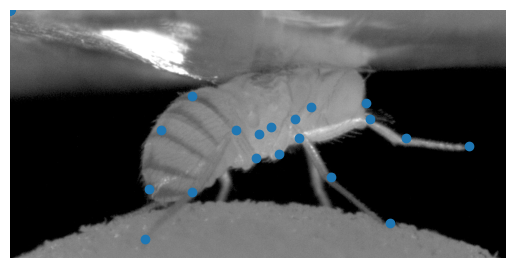

In [5]:
dataset = FLYDataset("/scratch/cv-course2025/group2/data")
plt.axis('off')
img, annotation = dataset.__getvisual__(200)
x, y = annotation
plt.imshow(img, cmap="grey")
plt.scatter(x, y)

plt.show(block=True)

In [3]:
class CNN_Fly(nn.Module):
    def __init__(self, input_size, embedding_size, num_joints=38):
        super().__init__()

        self.embedding_size = embedding_size
        self.num_joints = num_joints
        self.input_size = input_size  # expected: int or (H, W)

        """Encoder"""
        self.e1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.e2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.e3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.e4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.activation = nn.ReLU()

        """Bottleneck"""
        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_size) if isinstance(input_size, tuple) else torch.zeros(1, 1, input_size, input_size)
            dummy_out = self.encoder(dummy)
            self.flatten_dim = dummy_out.view(1, -1).shape[1]
            
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.flatten_dim, 2 * embedding_size)

        """Decoder"""
        self.d1 = nn.Linear(embedding_size, self.flatten_dim)
        self.d2 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.d3 = nn.ConvTranspose2d(64, 64, 2, stride=2, output_padding=0)
        self.d4 = nn.ConvTranspose2d(64, 32, 2, stride=2, output_padding=0)
        self.d5 = nn.ConvTranspose2d(32, 1, 3, padding=1)
        self.last_activation = nn.Sigmoid()

        """Keypoint regression head"""
        self.kp_head = nn.Sequential(
            nn.Linear(embedding_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_joints * 2)
        )

    def encoder(self, x):
        x = self.activation(self.e1(x))
        x = self.activation(self.e2(x))
        x = self.activation(self.e3(x))
        x = self.activation(self.e4(x))
        return x

    def decode_image(self, z):
        x = self.d1(z)
        x = x.view(-1, 64, int(self.input_size[0] / 4), int(self.input_size[1] / 4))  # adjust based on encoder strides
        x = self.activation(self.d2(x))
        x = self.activation(self.d3(x))
        x = self.activation(self.d4(x))
        x = self.d5(x)
        return self.last_activation(x)


    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        # Encode
        enc = self.encoder(x)
        flat = self.flatten(enc)
        z_params = self.linear(flat)
        mu, logvar = torch.chunk(z_params, 2, dim=1)
        z = self.reparametrize(mu, logvar)
        kp_out = self.kp_head(z)
        #img_out = self.decode_image(z)

        return kp_out.view(-1, self.num_joints, 2), z, mu, logvar
        #return img_out, z, mu, logvar


In [5]:
trnsforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),                 # Flip image horizontally with 50% chance (also flips keypoints if used)
    v2.RandomRotation(degrees=15),                  # Rotate image randomly between -15 and +15 degrees
    #v2.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast by up to ±20% #TODO Clarify: does this make sense as a transform for the data?
    v2.ToDtype(torch.float32, scale=True),          # Convert image to float32 and rescale pixel values from [0,255] → [0,1]
    v2.Normalize(mean=(0.5,), std=(0.5,))           # Normalize image: (x - 0.5) / 0.5 → values now in [-1, 1]
])

In [15]:
class CNN_Fly_Keypoints(nn.Module):
    def __init__(self, base_model, num_joints=38):
        super().__init__()
        self.base = base_model  # your CNN_Fly encoder + bottleneck
        self.num_joints = num_joints
        self.keypoint_head = nn.Sequential(
            nn.Linear(base_model.embedding_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_joints * 2)
        )

    def forward(self, x):
        _, z, _, _ = self.base(x)  # get the latent vector
        out = self.keypoint_head(z)
        return out.view(-1, self.num_joints, 2)  # reshape to [B, J, 2]


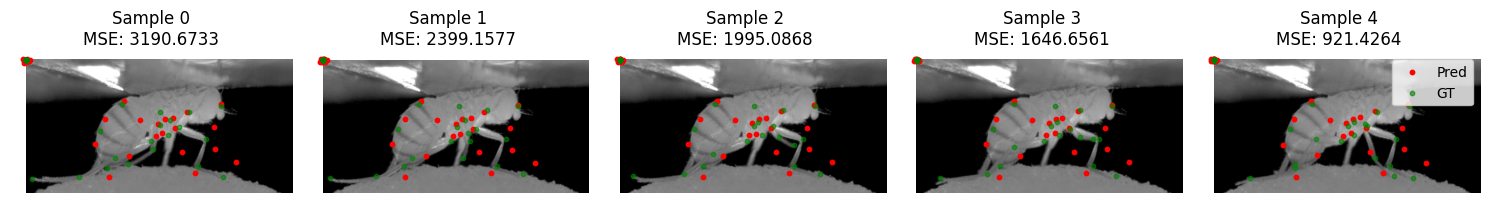


Average MSE over 5 samples: 2030.6001


In [7]:
# Train
def train_keypoint_model(model, dataset, num_epochs=10, batch_size=16, lr=1e-4, device="cuda"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, keypoints in loop:
            images = images.to(device)           # [B, 1, H, W]
            keypoints = keypoints.to(device)     # [B, J, 2]

            preds, _, _, _ = model(images)       # [B, J, 2]
            keypoints_px = keypoints.clone()
            keypoints_px[:, 0] *= dataset.H  # x
            keypoints_px[:, 1] *= dataset.W  # y

            preds_px = preds.clone()
            preds_px[:, 1] *= dataset.W
            preds_px[:, 0] *= dataset.H
            loss = loss_fn(preds_px, keypoints_px)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} - Avg Loss: {total_loss / len(dataloader):.4f}")
    
    torch.save(model.state_dict(), os.path.join('.', f'fly-test.pt'))

    return model


# Visualize
def visualize_predictions(model, dataset, device="cuda", num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    loss_fn = torch.nn.MSELoss()
    losses = []

    for i in range(num_samples):
        img, true_kp = dataset[i]

        input_img = img.unsqueeze(0).to(device)  # [1, 1, H, W]

        with torch.no_grad():
            pred_kp, _, _, _ = model(input_img)
            
        pred_kp = pred_kp.squeeze(0).cpu()
        true_kp = true_kp.cpu()
        # Compute MSE loss on normalized coordinates
        # loss = loss_fn(pred_kp, true_kp).item()
        # losses.append(loss)

        # Convert normalized to pixel coordinates
        true_kp_px = true_kp.clone()
        true_kp_px[:, 0] *= dataset.H  # x
        true_kp_px[:, 1] *= dataset.W  # y

        pred_kp_px = pred_kp.clone()
        pred_kp_px[:, 1] *= dataset.W
        pred_kp_px[:, 0] *= dataset.H

        loss = loss_fn(pred_kp_px, true_kp_px).item()
        losses.append(loss)

        img_np = img.squeeze(0).numpy()

        ax = axes[i]
        ax.imshow(img_np, cmap="gray")
        ax.scatter(pred_kp_px[:, 1], pred_kp_px[:, 0], c="r", label="Pred", s=10)
        ax.scatter(true_kp_px[:, 1], true_kp_px[:, 0], c="g", label="GT", s=10, alpha=0.6)
        ax.set_title(f"Sample {i}\nMSE: {loss:.4f}")
        ax.axis("off")

    plt.tight_layout()
    plt.legend()
    plt.show()
    avg_loss = sum(losses) / len(losses)
    print(f"\nAverage MSE over {num_samples} samples: {avg_loss:.4f}")

model = CNN_Fly(input_size=(480, 960), embedding_size=32)
train_dataset = FLYDataset("/scratch/cv-course2025/group2/data")
test_dataset = FLYDataset("/scratch/cv-course2025/group2/data", mode="test")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use CPU for debug so you do not use too much GPU time

#m = train_keypoint_model(model, dataset, num_epochs=1)
model.load_state_dict(torch.load("./fly-test.pt"))
model.to(device)
visualize_predictions(model, test_dataset, device=device)


In [ ]:
embedding_size = 64
kl_weight = 0.01
learning_rate = 1e-2
epochs = 101

vae = CNN_VAE(input_size, embedding_size).to(device)
optimizer = optim.SGD(vae.parameters(), lr=learning_rate, momentum=0.9)

print(f'\nVAE -- With LR = {learning_rate} AND KL_WEIGHT = {kl_weight}')

vae.zero_grad()
history_loss = []
history_val_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    running_recons_loss = 0.0
    running_kld_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, _ = data[0].to(device), data[1].to(device)
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        pred_x, _, pred_mean, pred_logvar = vae(inputs)
        loss = vae.loss_function(pred_x, inputs, pred_mean, pred_logvar, kl_weight=kl_weight)
        loss['loss'].backward()
        optimizer.step()

        running_loss += loss['loss'].item()
        running_recons_loss += loss['Reconstruction_Loss'].item()
        running_kld_loss += loss['KLD'].item()
    # output loss every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            running_val_loss = 0.0
            running_val_recons_loss = 0.0
            running_val_kld_loss = 0.0
            for j, data in enumerate(test_dataloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                if inputs.dim() == 3:
                    inputs = inputs.unsqueeze(1)
                pred_x, _, pred_mean, pred_logvar = vae(inputs)
                loss = vae.loss_function(pred_x, inputs, pred_mean, pred_logvar, kl_weight=kl_weight)

                running_val_loss += loss['loss'].item()
                running_val_recons_loss += loss['Reconstruction_Loss'].item()
                running_val_kld_loss += loss['KLD'].item()

            print(f'[{epoch + 1}] Loss: {running_loss / (i + 1):.5f} - Recons loss: {running_recons_loss / (i + 1):.5f}  '
                 f'- KLD: {running_kld_loss / (i + 1):.5f} || Val loss: {running_val_loss / (j + 1):.5f} '
                 f'- Recons val loss: {running_val_recons_loss / (j + 1):.5f}  - KLD: {running_val_kld_loss / (j + 1):.5f}')

        history_loss.append(running_loss / (i + 1))
        history_val_loss.append(running_val_loss / (j + 1))
        running_loss = 0.0

    # plot every n-th epoch
    if epoch % plot_nepoch == 0:
        rd_i = np.random.randint(inputs.shape[0])
        fig, axes = plt.subplots(1, 2)
        fig.suptitle(f'VAE - epoch {epoch} - loss {running_val_loss / (j + 1):.5f}')
        axes[0].imshow(inputs[rd_i].reshape((28, 28)).detach().cpu().numpy())
        axes[1].imshow(pred_x[rd_i].reshape((28, 28)).detach().cpu().numpy())
        plt.savefig(os.path.join(path_, f'cnnvae_ex_epoch{epoch}_emb-{embedding_size}.png'))

print('-- End training, saving model')
torch.save(vae.state_dict(), os.path.join(path_, f'mnist_cnnvae_emb-{embedding_size}_klweight-{kl_weight}.pt'))

# visualization
plt.figure()
plt.suptitle('Losses VAE')
plt.plot(np.arange(1, len(history_loss) * 10 + 1, 10), history_loss, label='loss')
plt.plot(np.arange(1, len(history_loss) * 10 + 1, 10), history_val_loss, '--', label='val_loss')
plt.legend()
plt.savefig(os.path.join(path_, f'losses_emb-{embedding_size}_klweight-{kl_weight}.png'))
plt.show()